In [1]:
import pandas as pd
from environment import root_dir
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import itertools
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
task_vis_results = pd.read_pickle(f"{root_dir}/results/results-tree-vis-v3.pkl")
generation_results = pd.read_pickle(f"{root_dir}/results/results-generation.pkl")
compare_results = pd.read_pickle(f"{root_dir}/results/results-tree-compare.pkl")

In [3]:
mpl.rcParams.update(mpl.rcParamsDefault)
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
# plt.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

In [11]:
models = {
    "deepseek-ai/deepseek-chat": {
        "label": "DeepSeek-V3", 
        "color": "#FADFA1",
        "color2": '#118AB2'
    },
    "deepseek-ai/deepseek-reasoner": {
        "label": "DeepSeek-R1", 
        "color": "#FFD166",
        "color2": '#073B4C'
    },   
    "alibaba/qwen2.5-32b-instruct": {
        "label": "Qwen2.5-32B", 
        "color": "#687B85", # "#7EADC6",
        "color2": '#118AB2'
    },
    "openrouter-qwen/qwq-32b": {
        "label": "QwQ-32B", 
        "color": "#073B4C", # "#118AB2",
        "color2": '#073B4C'
    },
}



metrics = {
    "average_forgetting_rate": {
        "label": r'Forgetting Rate ($r_{\mathrm{forget}}$)',
        "concise_label": r'$r_{\mathrm{forget}}$',
        "plain_label": "Forgetting Rate",
    },
    "average_solution_count": {
        "label": r'Solution Count ($\mathrel{\#}_{\mathrm{solution}}$)',
        "concise_label": r'$\mathrel{\#}_{\mathrm{solution}}$',
        "plain_label": "Solution Count",
    },
    "overall_average_verification_rate": {
        "label": r"Verification Rate ($r_{\mathrm{verify}}$)",
        "concise_label": r'$r_{\mathrm{verify}}$',
        "plain_label": "Verification Rate",
    },
    "filtered_ajd": {
        "label": r'Jump Distance ($d_{\mathrm{jump}}$)',
        "concise_label": r'$d_{\mathrm{jump}}$',
        "plain_label": "Jump Distance",
    },
    "average_success_rate": {
        "label": r'Success Rate ($r_{\mathrm{success}}$)',
        "concise_label": r'$r_{\mathrm{success}}$',
        "plain_label": "Success Rate",
    },
    "average_overthinking_rate": {
        "label": r'Overthinking Rate ($r_{\mathrm{overthinking}}$)',
        "concise_label": r'$r_{\mathrm{overthinking}}$',
        "plain_label": "Overthinking Rate",
    },
    "average_correlation": {
        "label": "Pass@1",
        "concise_label": "Pass@1",
        "plain_label": "Pass@1",
    },
}

dataset_metrics = {
    "math500": [
        "average_forgetting_rate",
        "average_solution_count",
        "overall_average_verification_rate",
        "filtered_ajd",
        "average_correlation",
    ],
    "game24": [
        "average_forgetting_rate",
        "average_solution_count",
        "overall_average_verification_rate",
        "filtered_ajd",
        "average_success_rate",
        "average_overthinking_rate",
        "average_correlation",
    ],
}

final_datasets = {
    'math500': "MATH-500", 
    'game24': "Game of 24",
}
final_metrics = [
    "average_correlation", 
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "average_overthinking_rate",
    "overall_average_verification_rate",
    "average_forgetting_rate",
]

In [5]:
def get_row(df, **kwargs):
    condition = None
    for key, value in kwargs.items():

        if condition is None:
            condition = df[key] == value
        else:
            condition &= df[key] == value
    return df[condition].reset_index(drop=True)

In [6]:
reasoning_metrics = {}
for dataset in final_datasets:
    reasoning_metrics[dataset] = {}
    for model in models:
        
        row = get_row(
            task_vis_results, 
            model_name=model, 
            dataset_name=dataset, 
            temperature = 0,
        )
        for metric in final_metrics:
            if metric not in reasoning_metrics[dataset]:
                reasoning_metrics[dataset][metric] = {}

            reasoning_metrics[dataset][metric][model] = row.iloc[0][metric]


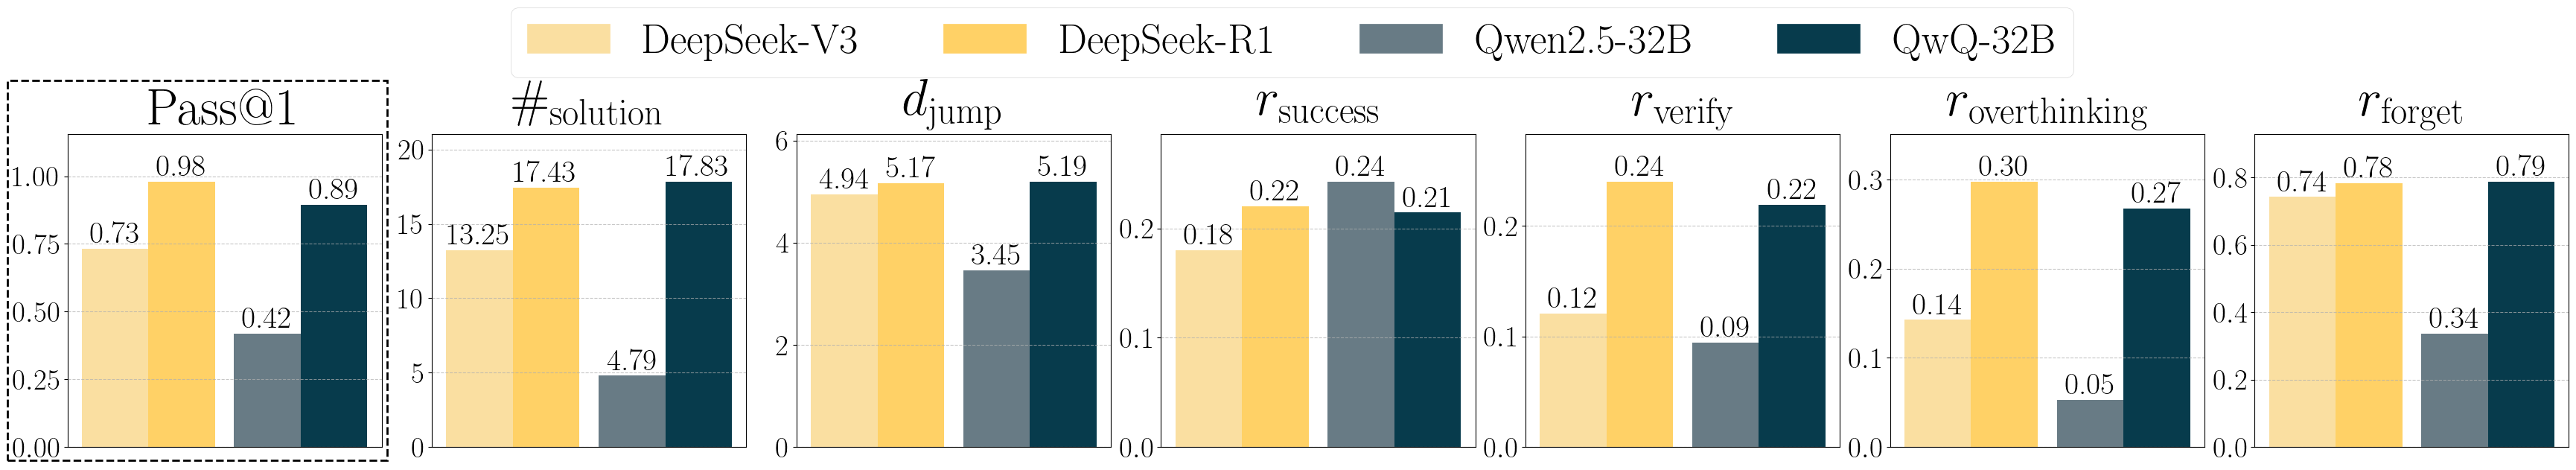

In [7]:
this_metrics = [
    "average_correlation",  # Put average_correlation first
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "overall_average_verification_rate",
    "average_overthinking_rate",
    "average_forgetting_rate",
]

# Create a figure with 1 row and 7 columns
fig, axs = plt.subplots(1, 7, figsize=(35, 6)) # Adjusted figsize
# Adjusted top for legend, bottom for potential x-axis label space if needed later (though currently empty)
fig.subplots_adjust(left=0.03, bottom=0.15, right=0.99, top=0.85, wspace=0.16) 

# Set width of individual bars and gap between groups
individual_bar_width = 0.35  # Width of each bar
group_gap = 0.1             # Space between the two groups of bars

dataset_key_to_plot = 'game24'
dataset_display_name = final_datasets[dataset_key_to_plot]

model_keys = list(models.keys())
# Using display labels for the legend directly
model_display_labels_for_legend = [models[m]["label"] for m in model_keys]
model_colors = [models[m]["color"] for m in model_keys]

# Calculate bar positions for grouping
calculated_positions = []
calculated_positions.append(0) 
calculated_positions.append(individual_bar_width) 
calculated_positions.append(individual_bar_width * 2 + group_gap) 
calculated_positions.append(individual_bar_width * 3 + group_gap) 


# Plot each metric in its own subplot
for col_idx, metric_key in enumerate(this_metrics):
    ax = axs[col_idx]
    metric_display_name = metrics[metric_key]["label"]

    if col_idx == 0: 
        ax.set_title(f"{metric_display_name}", fontsize=50, y=1.01) 
    else:
        ax.set_title(metric_display_name, fontsize=50, y=1.04) 

    metric_values = [reasoning_metrics[dataset_key_to_plot][metric_key][m] for m in model_keys]

    ax.bar(calculated_positions, metric_values, width=individual_bar_width, color=model_colors)

    # Remove x-axis ticks and labels
    ax.set_xticks([])
    ax.set_xticklabels([])
    
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    min_y_val = 0
    if any(val < 0 for val in metric_values) and metric_key == "average_correlation":
        min_val_actual = min(metric_values)
        min_y_val = min_val_actual - abs(min_val_actual * 0.1) 
    
    current_max_y = max(metric_values) if metric_values else 0
    if all(val == 0 for val in metric_values): 
        if metric_key == "average_correlation" and any(val < 0 for val in metric_values):
             max_y_padding_base = max(0.1, abs(min_y_val * 0.2)) 
        elif current_max_y == 0 and min_y_val == 0 : 
            max_y_padding_base = 0.1 
        else: 
            max_y_padding_base = abs(min_y_val) * 0.2 if min_y_val < 0 else current_max_y + 0.1
        max_y_val_adjusted = current_max_y + max_y_padding_base * 1.18 
        if max_y_val_adjusted == 0: max_y_val_adjusted = 0.1 
    else: 
        max_y_val_adjusted = current_max_y + abs(current_max_y - min_y_val) * 0.18 if current_max_y != min_y_val else current_max_y + 0.18

    ax.set_ylim(min_y_val, max_y_val_adjusted)

    for i, value in enumerate(metric_values):
        ax.text(calculated_positions[i], value, f'{value:.2f}', ha='center', va='bottom', fontsize=30)

# Add a dashed box around the first subplot (axs[0])
pos_ax0 = axs[0].get_position()
rect = plt.Rectangle(
    (pos_ax0.x0 - 0.023, pos_ax0.y0 - 0.03),  
    pos_ax0.width + 0.025,  
    pos_ax0.height + 0.15,  
    linewidth=2,
    linestyle='dashed',
    edgecolor='black',
    facecolor='none',
    zorder=1000, 
    transform=fig.transFigure,
    clip_on=False 
)
fig.add_artist(rect)

# Create legend handles and labels manually
legend_handles = [plt.Rectangle((0,0),1,1, color=models[m_key]["color"]) for m_key in model_keys]
# Use model_display_labels_for_legend for the legend text
fig.legend(legend_handles, model_display_labels_for_legend,
           loc='upper center', bbox_to_anchor=(0.5, 1.18), # Adjusted y for legend position
           ncol=len(models), frameon=True, fontsize=40) # Adjusted fontsize

# suptitle removed as per request

plt.savefig(f"{root_dir}/figures/lrmllm.pdf",bbox_inches='tight') 
plt.show()

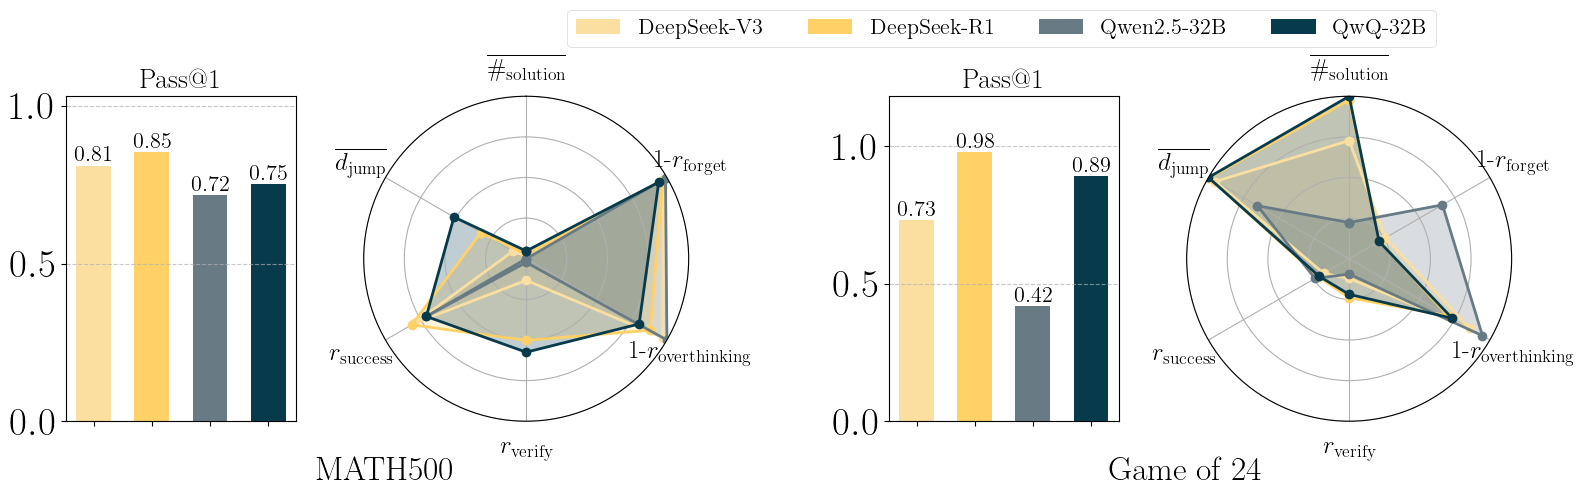

In [8]:
this_metrics = [
    "average_correlation",  # Put average_correlation first
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "overall_average_verification_rate",
    "average_overthinking_rate",
    "average_forgetting_rate",
]

# fig, axs = plt.subplots(1, 4, figsize=(20, 6), gridspec_kw={'width_ratios': [4, 6, 4, 6]})

# ADD THIS BLOCK TO REPLACE THE LINE ABOVE

# 1. Create the main figure
fig = plt.figure(figsize=(16, 5))

# 2. Create the main 1x2 GridSpec with the LARGE spacing between plot pairs
# This creates the big gap between the 2nd and 3rd plots.
gs_main = fig.add_gridspec(1, 2, wspace=0.3) 

# 3. Create a nested GridSpec for the left pair of plots (wspace=0.1)
gs_left = gs_main[0].subgridspec(1, 2, wspace=0.2, width_ratios=[4, 6])

# 4. Create a nested GridSpec for the right pair of plots (wspace=0.1)
gs_right = gs_main[1].subgridspec(1, 2, wspace=0.2, width_ratios=[4, 6])

# 5. Create the axes and put them in a list for your loop
axs = [
    fig.add_subplot(gs_left[0]),
    fig.add_subplot(gs_left[1]),
    fig.add_subplot(gs_right[0]),
    fig.add_subplot(gs_right[1]),
]

fig.subplots_adjust(left=0.05, bottom=0.15, right=0.96, top=0.8, hspace=0.3)

# Add titles for the left and right plot pairs
fig.text(0.25, 0.05, 'MATH500', ha='center', va='center', fontsize=24, fontweight='bold')
fig.text(0.75, 0.05, 'Game of 24', ha='center', va='center', fontsize=24, fontweight='bold')

# Process both datasets
datasets_to_plot = ["math500", "game24"]

# Pre-normalize radar metrics across both datasets
radar_metrics = this_metrics[1:]  # Skip average_correlation
global_normalized_data = {}

# Metrics that need normalization
metrics_to_normalize = ["average_solution_count", "filtered_ajd"]

for metric in radar_metrics:
    global_normalized_data[metric] = {}
    
    if metric in metrics_to_normalize:
        # Get all values for this metric across all models and datasets for normalization
        all_values = []
        for dataset_key in datasets_to_plot:
            for model in models:
                original_value = reasoning_metrics[dataset_key][metric][model]
                all_values.append(original_value)
        
        min_val = min(all_values)
        max_val = max(all_values)
        
        # Normalize to 0-1 range across both datasets
        for dataset_key in datasets_to_plot:
            global_normalized_data[metric][dataset_key] = {}
            for model in models:
                original_value = reasoning_metrics[dataset_key][metric][model]
                if max_val == min_val:
                    normalized_value = 0.5  # If all values are the same, set to middle
                else:
                    normalized_value = (original_value - min_val) / (max_val - min_val)
                global_normalized_data[metric][dataset_key][model] = normalized_value
    else:
        # For metrics that don't need normalization, just use original values
        for dataset_key in datasets_to_plot:
            global_normalized_data[metric][dataset_key] = {}
            for model in models:
                original_value = reasoning_metrics[dataset_key][metric][model]
                # Take inverse for overthinking and forgetting rates
                if metric in ["average_overthinking_rate", "average_forgetting_rate"]:
                    original_value = 1 - original_value
                global_normalized_data[metric][dataset_key][model] = original_value

for col_pair, dataset_key in enumerate(datasets_to_plot):
    dataset_name = final_datasets[dataset_key]
    bar_col = col_pair * 2
    radar_col = col_pair * 2 + 1
    
    # First subplot: Bar plot for average_correlation (pass@1)
    metric = "average_correlation"
    axs[bar_col].set_title(f"{metrics[metric]['label']}", fontsize=20, fontweight='bold')

    # Plot bars for each model
    bar_width = 0.6
    model_positions = np.arange(len(models))
    for j, model in enumerate(models):
        value = reasoning_metrics[dataset_key][metric][model]
        axs[bar_col].bar(j, value, bar_width, 
                  label=models[model]["label"], 
                  color=models[model]["color"])
        # Add value labels on top of bars
        axs[bar_col].text(j, value, f'{value:.2f}', ha='center', va='bottom', fontsize=16)

    axs[bar_col].set_xticks(model_positions)
    axs[bar_col].set_xticklabels([])  # Remove x-axis labels
    axs[bar_col].grid(axis='y', linestyle='--', alpha=0.7)
    current_ylim = axs[bar_col].get_ylim()
    axs[bar_col].set_ylim(0, current_ylim[1] * 1.15)
    
    # Add legend only to the first subplot
    if col_pair == 0:
        axs[bar_col].legend(loc='upper right', fontsize=16, ncol=5, bbox_to_anchor=(6, 1.3))

    # Turn off the regular subplot for radar plot
    axs[radar_col].axis('off')
    
    # --- START: CORRECTED CODE ---

    # Turn off the axis of the placeholder subplot
    axs[radar_col].axis('off')

    # Determine the correct GridSpec slicer based on the loop iteration
    if col_pair == 0:
        # This is the first pair of plots, use the second cell of the left GridSpec
        gs_slicer = gs_left[1]
    else:
        # This is the second pair, use the second cell of the right GridSpec
        gs_slicer = gs_right[1]

    # Create the new polar axes in the correct, specific location
    ax_radar = fig.add_subplot(gs_slicer, projection='polar')

    # --- END: CORRECTED CODE ---

    # Create 6 equally spaced angles for hexagon
    angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the hexagon

    # Plot each model using globally normalized data
    for model in models:
        values = []
        for metric in radar_metrics:
            values.append(global_normalized_data[metric][dataset_key][model])
        
        # Complete the hexagon
        values += values[:1]
        
        # Plot the line and fill
        ax_radar.plot(angles, values, 'o-', linewidth=2, 
                     label=models[model]["label"], color=models[model]["color"])
        ax_radar.fill(angles, values, alpha=0.25, color=models[model]["color"])

    # Customize the radar plot to be hexagonal
    ax_radar.set_xticks(angles[:-1])
    # Create labels with 1-original for overthinking and forgetting rates
    radar_labels = []
    for metric in radar_metrics:
        if metric in ["average_overthinking_rate", "average_forgetting_rate"]:
            radar_labels.append(f"1-{metrics[metric]['label']}")
        elif metric in ["average_solution_count", "filtered_ajd"]:
            label = metrics[metric]["label"].replace("$", "")
            radar_labels.append(f"$\\overline{{{label}}}$")
        else:
            radar_labels.append(metrics[metric]["label"])
    ax_radar.set_xticklabels(radar_labels, fontsize=18)
    ax_radar.set_ylim(0, 1)
    ax_radar.set_yticklabels([])  # <-- ADD THIS LINE
    ax_radar.grid(True)

    # Make the plot hexagonal by setting theta direction and zero location
    ax_radar.set_theta_direction(1)
    ax_radar.set_theta_zero_location('N')

    # Adjust label distance to prevent overlap with the radar plot
    ax_radar.tick_params(axis='x', pad=10)

    # Add title to radar plot
    # ax_radar.set_title(f"{dataset_name} - Other Metrics", fontsize=18, fontweight='bold', pad=20)

plt.savefig(f"{root_dir}/figures/lrm_llm_radar.pdf")



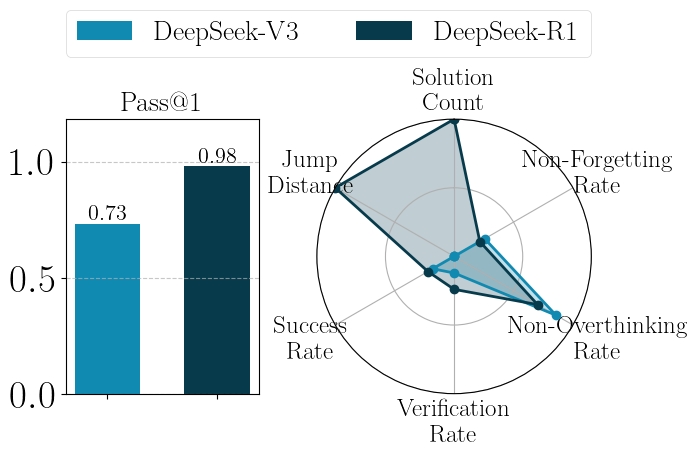

In [28]:
this_metrics = [
    "average_correlation",  # Put average_correlation first
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "overall_average_verification_rate",
    "average_overthinking_rate",
    "average_forgetting_rate",
]

# Create a single figure with 1x2 layout
fig, axs = plt.subplots(1, 2, figsize=(7, 4.5), gridspec_kw={'width_ratios': [3, 6]})
fig.subplots_adjust(left=0.1, bottom=0.13, right=0.93, top=0.74, hspace=0.3, wspace=0.01)

# Focus on Game of 24 dataset only
dataset_key = "game24"
dataset_name = final_datasets[dataset_key]

# Define model pair for comparison - only DeepSeek models
model_pair = ["deepseek-ai/deepseek-chat", "deepseek-ai/deepseek-reasoner"]

# Pre-normalize radar metrics for the selected models
radar_metrics = this_metrics[1:]  # Skip average_correlation
global_normalized_data = {}

# Metrics that need normalization
metrics_to_normalize = ["average_solution_count", "filtered_ajd"]

for metric in radar_metrics:
    global_normalized_data[metric] = {}
    
    if metric in metrics_to_normalize:
        # Get all values for this metric across selected models for normalization
        all_values = []
        for model in model_pair:
            original_value = reasoning_metrics[dataset_key][metric][model]
            all_values.append(original_value)
        
        min_val = min(all_values)
        max_val = max(all_values)
        
        # Normalize to 0-1 range
        global_normalized_data[metric][dataset_key] = {}
        for model in model_pair:
            original_value = reasoning_metrics[dataset_key][metric][model]
            if max_val == min_val:
                normalized_value = 0.5  # If all values are the same, set to middle
            else:
                normalized_value = (original_value - min_val) / (max_val - min_val)
            global_normalized_data[metric][dataset_key][model] = normalized_value
    else:
        # For metrics that don't need normalization, just use original values
        global_normalized_data[metric][dataset_key] = {}
        for model in model_pair:
            original_value = reasoning_metrics[dataset_key][metric][model]
            # Take inverse for overthinking and forgetting rates
            if metric in ["average_overthinking_rate", "average_forgetting_rate"]:
                original_value = 1 - original_value
            global_normalized_data[metric][dataset_key][model] = original_value

# First subplot: Bar plot for average_correlation (pass@1)
metric = "average_correlation"
axs[0].set_title(f"{metrics[metric]['label']}", fontsize=20, fontweight='bold')

# Plot bars for each model in the pair
bar_width = 0.6
model_positions = np.arange(len(model_pair))
for j, model in enumerate(model_pair):
    value = reasoning_metrics[dataset_key][metric][model]
    axs[0].bar(j, value, bar_width, 
              label=models[model]["label"], 
              color=models[model]["color2"])
    # Add value labels on top of bars
    axs[0].text(j, value, f'{value:.2f}', ha='center', va='bottom', fontsize=16)

axs[0].set_xticks(model_positions)
axs[0].set_xticklabels([])  # Remove x-axis labels
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
current_ylim = axs[0].get_ylim()
axs[0].set_ylim(0, current_ylim[1] * 1.15)

# Add legend
axs[0].legend(loc='upper right', fontsize=20, bbox_to_anchor=(2.8, 1.45), ncol=2)

# Turn off the regular subplot for radar plot
axs[1].axis('off')

# Create polar axes for radar plot
ax_radar = fig.add_subplot(1, 2, 2, projection='polar')

# Create 6 equally spaced angles for hexagon
angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the hexagon

# Plot each model in the pair using globally normalized data
for model in model_pair:
    values = []
    for metric in radar_metrics:
        values.append(global_normalized_data[metric][dataset_key][model])
    
    # Complete the hexagon
    values += values[:1]
    
    # Plot the line and fill
    ax_radar.plot(angles, values, 'o-', linewidth=2, 
                 label=models[model]["label"], color=models[model]["color2"])
    ax_radar.fill(angles, values, alpha=0.25, color=models[model]["color2"])

# Customize the radar plot to be hexagonal
ax_radar.set_xticks(angles[:-1])
# Create labels with 1-original for overthinking and forgetting rates
radar_labels = []
for metric in radar_metrics:
    if metric in ["average_overthinking_rate", "average_forgetting_rate"]:
        label = metrics[metric]["plain_label"].replace(" ", "\n")
        radar_labels.append(f"Non-{label}")
    elif metric in ["average_solution_count", "filtered_ajd"]:
        label = metrics[metric]["plain_label"].replace(" ", "\n")
        radar_labels.append(label.replace(" ", "\n"))
    else:
        radar_labels.append(metrics[metric]["plain_label"].replace(" ", "\n"))
ax_radar.set_xticklabels(radar_labels, fontsize=18)
ax_radar.set_ylim(0, 1)
ax_radar.set_yticklabels([])  # Remove radial tick labels
ax_radar.grid(True)

# Make the plot hexagonal by setting theta direction and zero location
ax_radar.set_theta_direction(1)
ax_radar.set_theta_zero_location('N')

# Adjust label distance to prevent overlap with the radar plot
ax_radar.tick_params(axis='x', pad=10)

plt.savefig(f"{root_dir}/figures/lrm_llm_radar_{dataset_key}_deepseek.pdf")


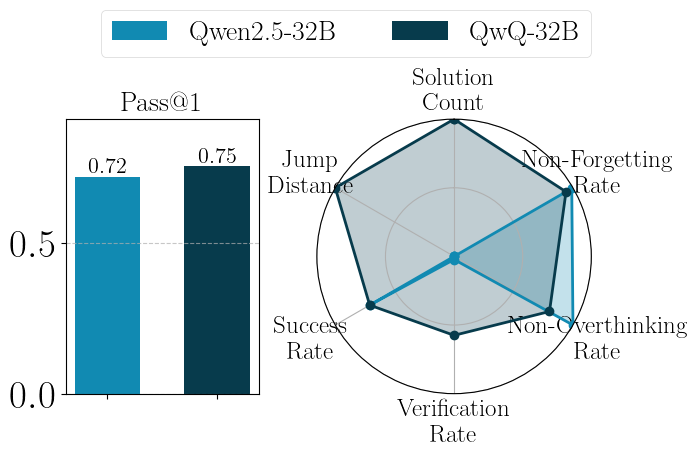

In [31]:
this_metrics = [
    "average_correlation",  # Put average_correlation first
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "overall_average_verification_rate",
    "average_overthinking_rate",
    "average_forgetting_rate",
]

# Create a single figure with 1x2 layout
fig, axs = plt.subplots(1, 2, figsize=(7, 4.5), gridspec_kw={'width_ratios': [3, 6]})
fig.subplots_adjust(left=0.1, bottom=0.13, right=0.93, top=0.74, hspace=0.3, wspace=0.01)

# Focus on Game of 24 dataset only
dataset_key = "math500"
dataset_name = final_datasets[dataset_key]

# Define model pair for comparison - only Qwen models
model_pair = ["alibaba/qwen2.5-32b-instruct", "openrouter-qwen/qwq-32b"]

# Pre-normalize radar metrics for the selected models
radar_metrics = this_metrics[1:]  # Skip average_correlation
global_normalized_data = {}

# Metrics that need normalization
metrics_to_normalize = ["average_solution_count", "filtered_ajd"]

for metric in radar_metrics:
    global_normalized_data[metric] = {}
    
    if metric in metrics_to_normalize:
        # Get all values for this metric across selected models for normalization
        all_values = []
        for model in model_pair:
            original_value = reasoning_metrics[dataset_key][metric][model]
            all_values.append(original_value)
        
        min_val = min(all_values)
        max_val = max(all_values)
        
        # Normalize to 0-1 range
        global_normalized_data[metric][dataset_key] = {}
        for model in model_pair:
            original_value = reasoning_metrics[dataset_key][metric][model]
            if max_val == min_val:
                normalized_value = 0.5  # If all values are the same, set to middle
            else:
                normalized_value = (original_value - min_val) / (max_val - min_val)
            global_normalized_data[metric][dataset_key][model] = normalized_value
    else:
        # For metrics that don't need normalization, just use original values
        global_normalized_data[metric][dataset_key] = {}
        for model in model_pair:
            original_value = reasoning_metrics[dataset_key][metric][model]
            # Take inverse for overthinking and forgetting rates
            if metric in ["average_overthinking_rate", "average_forgetting_rate"]:
                original_value = 1 - original_value
            global_normalized_data[metric][dataset_key][model] = original_value

# First subplot: Bar plot for average_correlation (pass@1)
metric = "average_correlation"
axs[0].set_title(f"{metrics[metric]['label']}", fontsize=20, fontweight='bold')

# Plot bars for each model in the pair
bar_width = 0.6
model_positions = np.arange(len(model_pair))
for j, model in enumerate(model_pair):
    value = reasoning_metrics[dataset_key][metric][model]
    axs[0].bar(j, value, bar_width, 
              label=models[model]["label"], 
              color=models[model]["color2"])
    # Add value labels on top of bars
    axs[0].text(j, value, f'{value:.2f}', ha='center', va='bottom', fontsize=16)

axs[0].set_xticks(model_positions)
axs[0].set_xticklabels([])  # Remove x-axis labels
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
current_ylim = axs[0].get_ylim()
axs[0].set_ylim(0, current_ylim[1] * 1.15)

# Add legend
axs[0].legend(loc='upper right', fontsize=20, bbox_to_anchor=(2.8, 1.45), ncol=2)

# Turn off the regular subplot for radar plot
axs[1].axis('off')

# Create polar axes for radar plot
ax_radar = fig.add_subplot(1, 2, 2, projection='polar')

# Create 6 equally spaced angles for hexagon
angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the hexagon

# Plot each model in the pair using globally normalized data
for model in model_pair:
    values = []
    for metric in radar_metrics:
        values.append(global_normalized_data[metric][dataset_key][model])
    
    # Complete the hexagon
    values += values[:1]
    
    # Plot the line and fill
    ax_radar.plot(angles, values, 'o-', linewidth=2, 
                 label=models[model]["label"], color=models[model]["color2"])
    ax_radar.fill(angles, values, alpha=0.25, color=models[model]["color2"])

# Customize the radar plot to be hexagonal
ax_radar.set_xticks(angles[:-1])
# Create labels with 1-original for overthinking and forgetting rates
radar_labels = []
for metric in radar_metrics:
    if metric in ["average_overthinking_rate", "average_forgetting_rate"]:
        label = metrics[metric]["plain_label"].replace(" ", "\n")
        radar_labels.append(f"Non-{label}")
    elif metric in ["average_solution_count", "filtered_ajd"]:
        label = metrics[metric]["plain_label"].replace(" ", "\n")
        radar_labels.append(label.replace(" ", "\n"))
    else:
        radar_labels.append(metrics[metric]["plain_label"].replace(" ", "\n"))
ax_radar.set_xticklabels(radar_labels, fontsize=18)
ax_radar.set_ylim(0, 1)
ax_radar.set_yticklabels([])  # Remove radial tick labels
ax_radar.grid(True)

# Make the plot hexagonal by setting theta direction and zero location
ax_radar.set_theta_direction(1)
ax_radar.set_theta_zero_location('N')

# Adjust label distance to prevent overlap with the radar plot
ax_radar.tick_params(axis='x', pad=10)

plt.savefig(f"{root_dir}/figures/lrm_llm_radar_{dataset_key}_qwen.pdf")
